In [1]:
from pyspark.sql import SparkSession, functions as F
from pyspark.sql.functions import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

spark = (
    SparkSession.builder.appName("ADS project 2")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.executor.memory", "2g")
    .config("spark.driver.memory", "4g")
    .getOrCreate()
)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/10/13 16:56:12 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/10/13 16:56:14 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/10/13 16:56:14 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


In [25]:
df = spark.read.parquet("../data/curated/merchant_consumer_abs")

<h2>Determine the monthly increase/decrease for merchants</h2>

In [26]:
revenue_monthly = df.groupBy(["merchant_name", "order_year", "order_month"]).agg(sum("dollar_value").alias("total_dollar_value"))
revenue_annually = df.groupBy(["merchant_name", "order_year"]).agg(sum("dollar_value").alias("total_dollar_value"))

In [27]:
revenue_monthly = revenue_monthly.toPandas()
revenue_annually = revenue_annually.toPandas()

In [28]:
revenue_monthly = revenue_monthly.sort_values(["merchant_name", "order_year", "order_month"])
revenue_annually = revenue_annually.sort_values(["merchant_name", "order_year"])

In [29]:
merchants = list(set(revenue_monthly["merchant_name"].unique()))

<h3>1. Observe the growth trend of the revenue based on merchants</h3>

/var/folders/jf/lpq30w0s4qv628ncd2qlm8nc0000gn/T/ipykernel_80899/868243603.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merchant["period"] = merchant["order_year"].astype(str) + "-" + merchant["order_month"].astype(str)


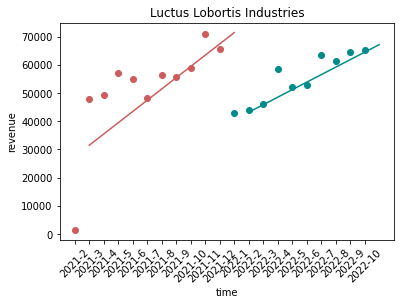

/var/folders/jf/lpq30w0s4qv628ncd2qlm8nc0000gn/T/ipykernel_80899/868243603.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merchant["period"] = merchant["order_year"].astype(str) + "-" + merchant["order_month"].astype(str)


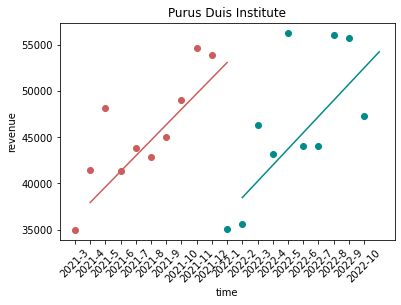

/var/folders/jf/lpq30w0s4qv628ncd2qlm8nc0000gn/T/ipykernel_80899/868243603.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merchant["period"] = merchant["order_year"].astype(str) + "-" + merchant["order_month"].astype(str)


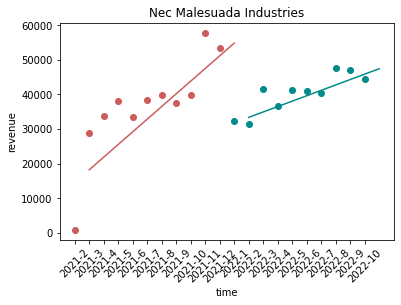

/var/folders/jf/lpq30w0s4qv628ncd2qlm8nc0000gn/T/ipykernel_80899/868243603.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merchant["period"] = merchant["order_year"].astype(str) + "-" + merchant["order_month"].astype(str)


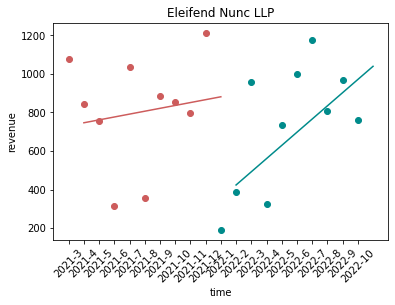

In [30]:
for i in range(600, 604):
    merchant = revenue_monthly[revenue_monthly["merchant_name"] == merchants[i]]
    merchant["period"] = merchant["order_year"].astype(str) + "-" + merchant["order_month"].astype(str)
    x = merchant['period']
    y = merchant['total_dollar_value']

    year21 = len(merchant[merchant["order_year"] == 2021])
    if (year21 != 0):
        x1 = merchant[merchant["order_year"] == 2021]['period']
        y1 = merchant[merchant["order_year"] == 2021]['total_dollar_value']
        plt.scatter(x1, y1, color="indianred")
        xNum1 = np.array(range(1, year21+1))
        a1, b1 = np.polyfit(xNum1, y[:year21], 1)
        plt.plot(xNum1, a1*xNum1+b1, color="indianred")

    year22 = len(merchant[merchant["order_year"] == 2022])
    if (year22 != 0):
        x2 = merchant[merchant["order_year"] == 2022]['period']
        y2 = merchant[merchant["order_year"] == 2022]['total_dollar_value']
        plt.scatter(x2, y2, color="darkcyan")
        xNum2 = np.array(range(year21+1, len(x)+1))
        a2, b2 = np.polyfit(xNum2, y[year21:len(x)], 1)
        plt.plot(xNum2, a2*xNum2+b2, color="darkcyan")
    
    plt.xticks(rotation=45)
    plt.title(merchants[i])
    plt.xlabel("time")
    plt.ylabel("revenue")
    plt.show()

<h4>There are some example above, suggesting the revenue level is related to the month of year for some merchants.</h4>

<h3>2. calculate the average monthly increase/decrease for the merchants</h3>

In [31]:
revenue_increasing = []
count = 0
for i in range(len(merchants)):
    merchant_increasing = []
    merchant = revenue_annually[revenue_annually["merchant_name"] == merchants[i]]
    merchant_increasing.append(merchants[i])
    if len(merchant) == 1:
        count+=1
        if ((merchant["order_year"] == 2022).values):
            merchant_increasing.append((merchant["total_dollar_value"]).values[0]/10)
            revenue_increasing.append(merchant_increasing)
        if ((merchant["order_year"] == 2021).values):
            merchant_increasing.append(-((merchant["total_dollar_value"]).values[0]/10))
            revenue_increasing.append(merchant_increasing)
    if len(merchant) == 2:
        merchant_increasing.append(((merchant[merchant["order_year"] == 2022]["total_dollar_value"]).values - (merchant[merchant["order_year"] == 2021]["total_dollar_value"]).values)[0]/10)
        revenue_increasing.append(merchant_increasing)

In [32]:
result = pd.DataFrame(revenue_increasing, columns=["merchant_name", "monthly_increase_rate"])
result

,merchant_name,monthly_increase_rate
0,Aliquet Industries,246.721693
1,Sed Eu Institute,141.104280
2,Ac Eleifend PC,-414.360809
3,Faucibus Leo Ltd,-1286.070581
4,Fringilla Donec Associates,-319.945472
...,...,...
3890,Eu Erat Semper Inc.,-332.858855
3891,Quam Dignissim Pharetra Foundation,92.052301
3892,Varius Nam Porttitor Consulting,-333.387922
3893,Auctor Inc.,1490.661920


In [33]:
result.to_csv("../data/curated/increasing.csv", index = False)

22/10/10 12:21:38 WARN TransportChannelHandler: Exception in connection from dongmensMacBook/192.168.20.8:51001
java.io.IOException: Operation timed out
	at sun.nio.ch.FileDispatcherImpl.read0(Native Method)
	at sun.nio.ch.SocketDispatcher.read(SocketDispatcher.java:39)
	at sun.nio.ch.IOUtil.readIntoNativeBuffer(IOUtil.java:223)
	at sun.nio.ch.IOUtil.read(IOUtil.java:192)
	at sun.nio.ch.SocketChannelImpl.read(SocketChannelImpl.java:379)
	at io.netty.buffer.PooledByteBuf.setBytes(PooledByteBuf.java:258)
	at io.netty.buffer.AbstractByteBuf.writeBytes(AbstractByteBuf.java:1132)
	at io.netty.channel.socket.nio.NioSocketChannel.doReadBytes(NioSocketChannel.java:350)
	at io.netty.channel.nio.AbstractNioByteChannel$NioByteUnsafe.read(AbstractNioByteChannel.java:151)
	at io.netty.channel.nio.NioEventLoop.processSelectedKey(NioEventLoop.java:722)
	at io.netty.channel.nio.NioEventLoop.processSelectedKeysOptimized(NioEventLoop.java:658)
	at io.netty.channel.nio.NioEventLoop.processSelectedKeys(Ni